In [117]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from catboost import CatBoostRegressor
import optuna
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import mutual_info_regression
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import GridSearchCV


In [118]:
# Load dataset
df = pd.read_csv('test-data/2015_to_2022_dataset.csv')

In [119]:
# Replace missing values with NaN
df.replace("", np.nan, inplace=True)

In [120]:
df.isnull().sum()

Code                         0
Locale                       0
Date                         0
Temperature                  7
Precipitation            63134
Wind_Speed                  55
Wind_Direction              68
Humidity                    35
Vapor_Pressure               7
Dew_Point_Temperature       10
Spot_Atm_Pressure           21
Sea_Level_Pressure          17
Daylight_Time            32027
Insolation               31852
Snowfall_Amount          68051
Clouds_Amount             7111
Ground_Temperature          67
SO2                       1486
CO                        2672
NO2                       2074
PM10                      1436
PM2_5                     1330
O3                        1397
dtype: int64

# Pre-processing

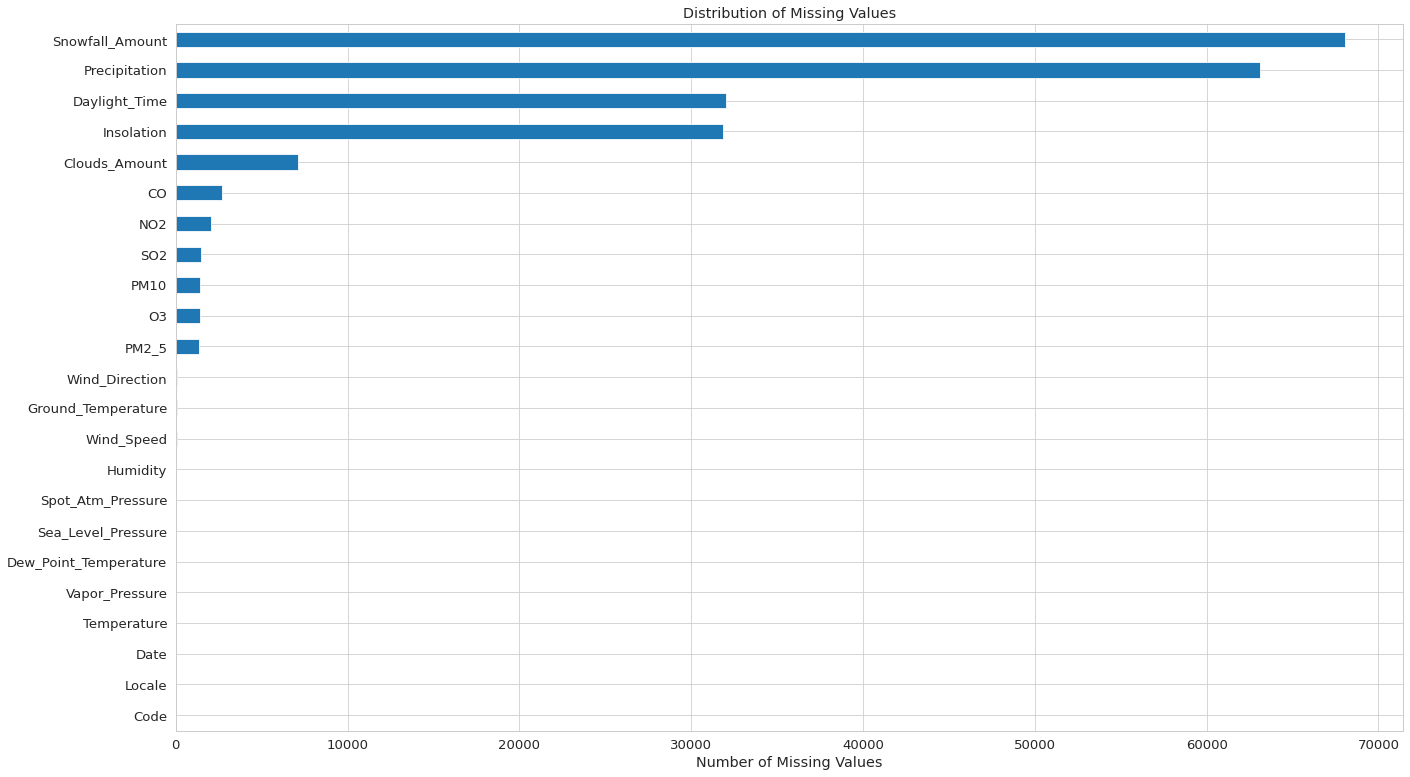

In [121]:
# Your data
nan_distribution = df.isnull().sum()

# Convert the dictionary to a pandas Series for easier plotting
nan_series = pd.Series(nan_distribution)

# Create the plot
plt.figure(figsize=(22, 13))
nan_series.sort_values().plot(kind='barh')
plt.xlabel('Number of Missing Values')
plt.title('Distribution of Missing Values')
plt.show()

In [122]:
# Define the columns to be imputed with the median
median_columns = [
    'Temperature', 'Wind_Speed', 'Wind_Direction', 'Humidity',
    'Vapor_Pressure', 'Dew_Point_Temperature', 'Spot_Atm_Pressure',
    'Sea_Level_Pressure', 'SO2', 'CO', 'NO2', 'PM10', 'PM2_5', 'O3',
    'Ground_Temperature'
]

# Define the columns to be imputed with zero
zeroing_columns = [
    'Precipitation', 'Daylight_Time', 'Insolation',
    'Snowfall_Amount', 'Clouds_Amount'
]

# Create imputer for median
imputer_median = SimpleImputer(strategy='median')

# Apply the imputer to the columns that require the median
df[median_columns] = imputer_median.fit_transform(df[median_columns])

# Fill the NaN values with zero for the columns that require zeroing
df[zeroing_columns] = df[zeroing_columns].fillna(0)

# Check if there are any remaining NaN values
print(df.isnull().sum())

Code                     0
Locale                   0
Date                     0
Temperature              0
Precipitation            0
Wind_Speed               0
Wind_Direction           0
Humidity                 0
Vapor_Pressure           0
Dew_Point_Temperature    0
Spot_Atm_Pressure        0
Sea_Level_Pressure       0
Daylight_Time            0
Insolation               0
Snowfall_Amount          0
Clouds_Amount            0
Ground_Temperature       0
SO2                      0
CO                       0
NO2                      0
PM10                     0
PM2_5                    0
O3                       0
dtype: int64


### 1. YYMMDD

In [123]:
df['Date'] = pd.to_datetime(df['Date'])
df['Date'] = df['Date'].dt.strftime('%y%m%d')
df['Date'] = df['Date'].astype(int)

In [124]:
df = df.drop(columns = ['Code', 'Locale'])

In [125]:
# Specify the target variable
y = df['O3']

In [126]:
# Specify the feature variables
X = df.drop(['Date', 'O3'], axis=1)
X_origin = X

In [127]:
# Feature Scaling
scaler = StandardScaler()
X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

In [129]:
features = [
            'Temperature', 
            'Precipitation', 
            'Wind_Speed', 
            'Wind_Direction', 
            'Humidity', 
            'Vapor_Pressure', 
            'Dew_Point_Temperature', 
            'Spot_Atm_Pressure', 
            'Sea_Level_Pressure',
            'Daylight_Time', 
            'Insolation', 
            'Snowfall_Amount', 
            'Clouds_Amount',
            'Ground_Temperature',
            'SO2',
            'CO',
            'NO2',
            'PM10',
            'PM2_5',
           ]

In [135]:
df

,Date,Temperature,Precipitation,Wind_Speed,Wind_Direction,Humidity,Vapor_Pressure,Dew_Point_Temperature,Spot_Atm_Pressure,Sea_Level_Pressure,...,Insolation,Snowfall_Amount,Clouds_Amount,Ground_Temperature,SO2,CO,NO2,PM10,PM2_5,O3
0,150101,14.4,0.0,6.1,290.0,61.0,9.3,5.9,1006.3,1016.6,...,0.0,0.0,0.0,14.8,0.006,0.6,0.011,46.0,19.0,0.022
1,150101,-7.4,0.0,4.7,290.0,33.0,1.2,-20.9,1011.8,1023.0,...,0.0,0.0,0.0,-4.5,0.006,0.6,0.011,44.0,7.0,0.022
2,150101,-8.0,0.0,4.5,290.0,35.0,1.2,-20.8,1011.7,1022.9,...,0.0,0.0,0.0,-5.1,0.006,0.6,0.010,57.0,10.0,0.022
3,150101,-8.4,0.0,3.8,290.0,37.0,1.2,-20.5,1012.1,1023.3,...,0.0,0.0,0.0,-5.5,0.006,0.6,0.010,76.0,10.0,0.021
4,150101,-8.8,0.0,4.9,290.0,35.0,1.1,-21.5,1012.3,1023.6,...,0.0,0.0,0.0,-5.9,0.006,0.6,0.009,86.0,11.0,0.022
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70123,221231,-0.2,0.0,1.8,20.0,73.0,4.4,-4.4,1018.5,1029.4,...,0.0,0.0,0.0,-0.9,0.004,1.1,0.064,65.0,59.0,0.004
70124,221231,-0.8,0.0,1.4,20.0,75.0,4.3,-4.6,1018.1,1029.0,...,0.0,0.0,4.0,-1.8,0.005,1.2,0.065,69.0,59.0,0.004
70125,221231,-1.0,0.0,0.9,340.0,77.0,4.4,-4.5,1018.2,1029.2,...,0.0,0.0,7.0,-2.8,0.004,1.3,0.066,67.0,62.0,0.004
70126,221231,-0.8,0.0,0.5,290.0,78.0,4.5,-4.1,1018.3,1029.3,...,0.0,0.0,8.0,-2.2,0.004,1.3,0.066,63.0,62.0,0.004


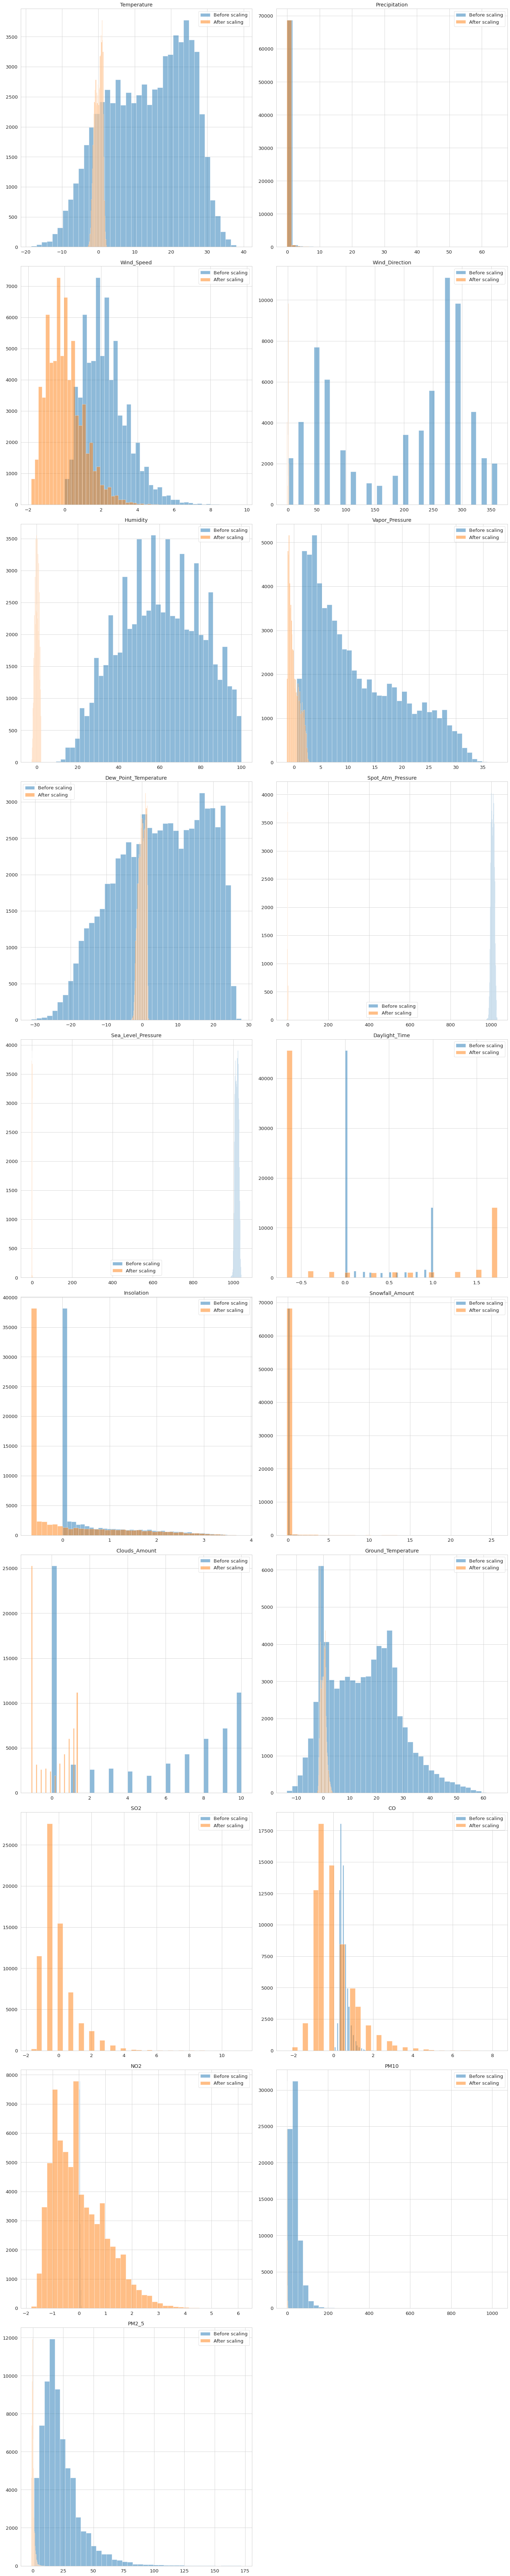

In [138]:
# Determine the number of rows and columns for the subplots
n = len(features)
ncols = 2
nrows = n // ncols + (n % ncols > 0)

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, 10*nrows))

# Flatten the axes array and delete extra subplots if the number of features is not even
axes = axes.flatten()
if n % ncols > 0:
    [ax.remove() for ax in axes[n:]]

# Plot the histograms of each feature before and after scaling
for ax, feature in zip(axes, features):
    ax.hist(X_origin[feature], bins=40, alpha=0.5, label='Before scaling')
    ax.hist(X[feature], bins=40, alpha=0.5, label='After scaling')
    ax.set_title(feature)
    ax.legend()

plt.tight_layout()
plt.show()

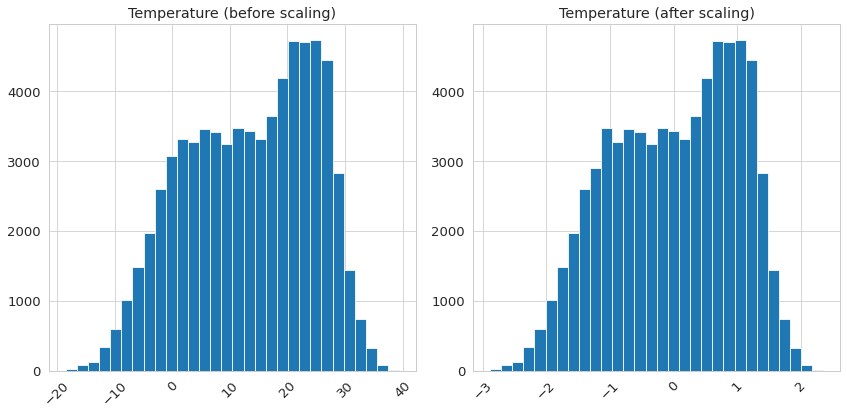

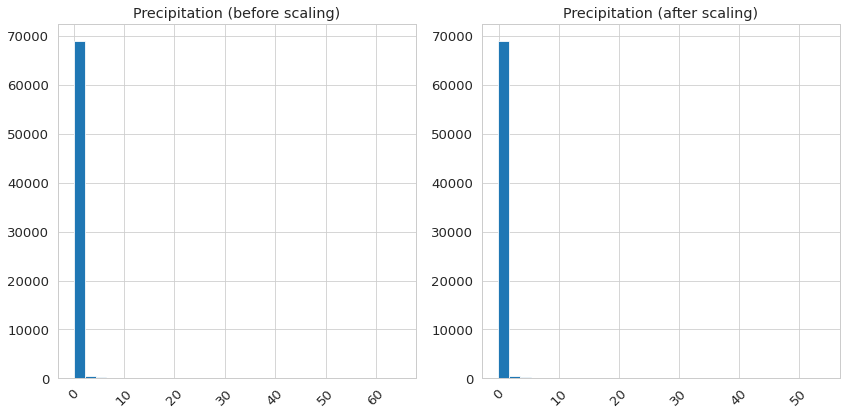

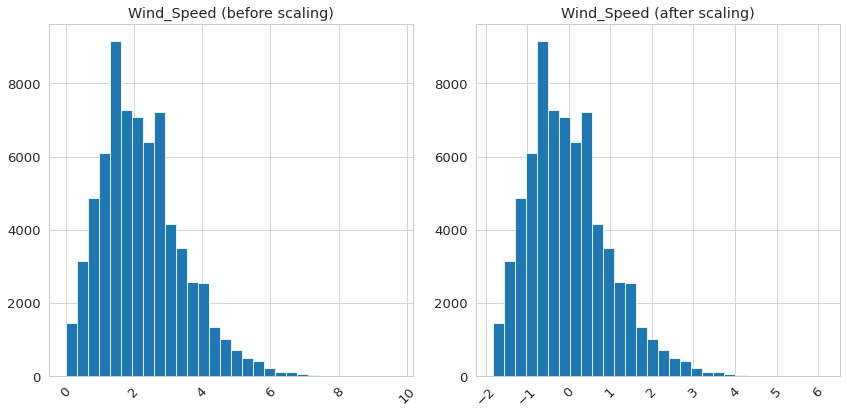

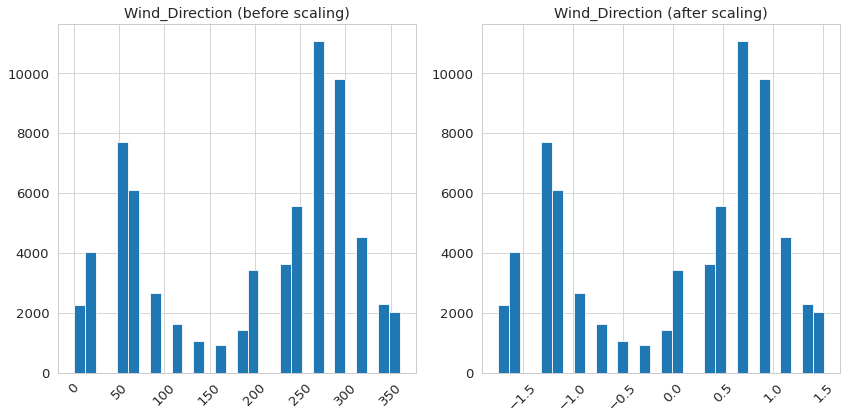

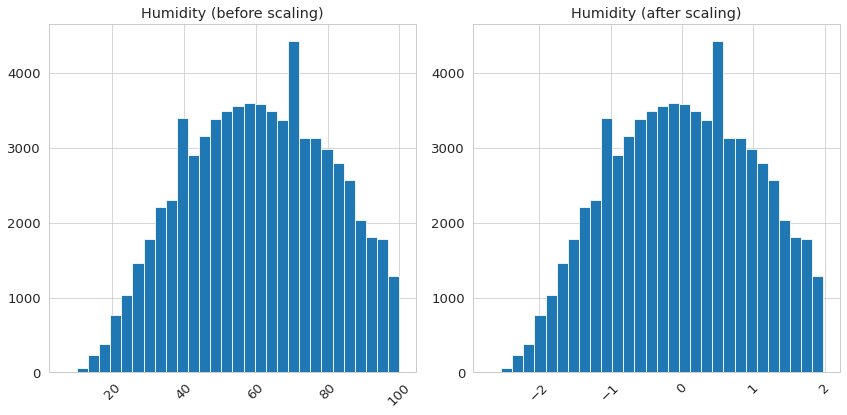

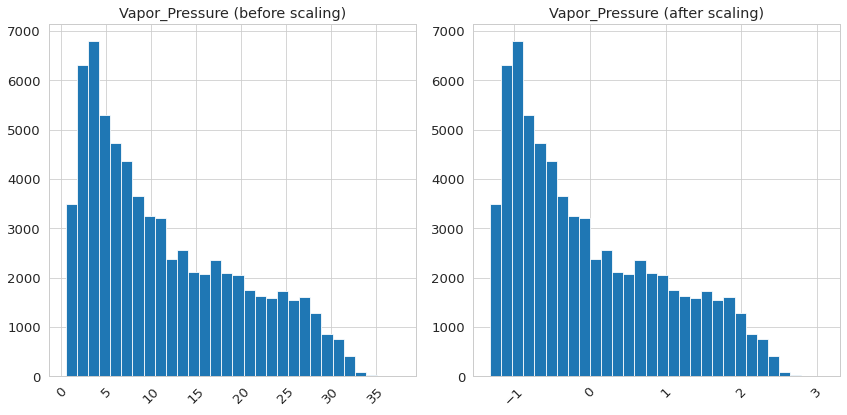

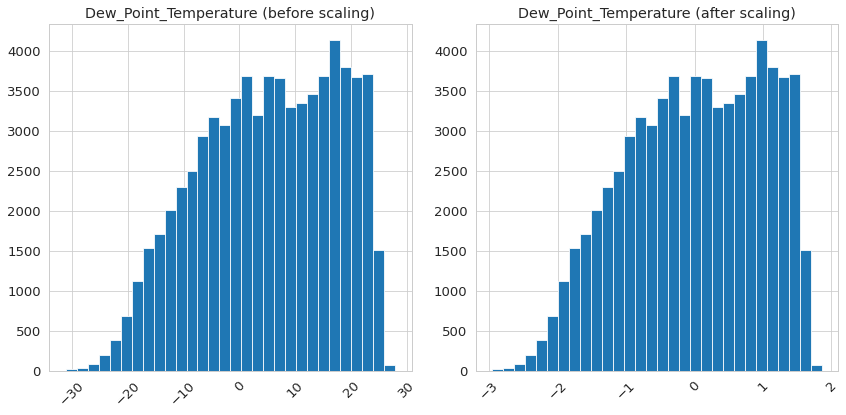

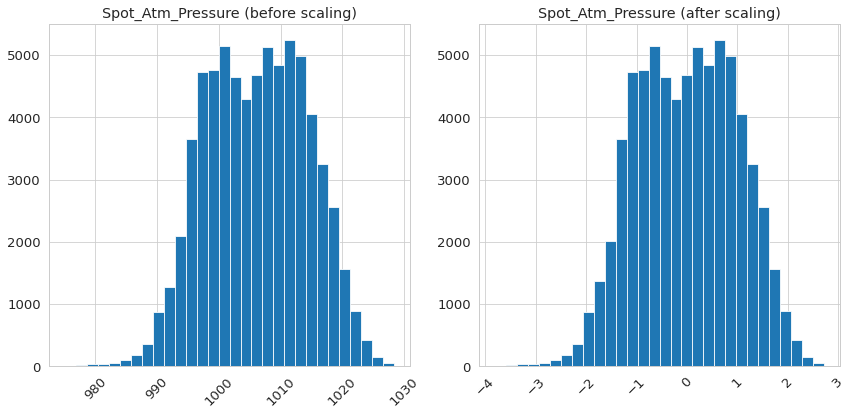

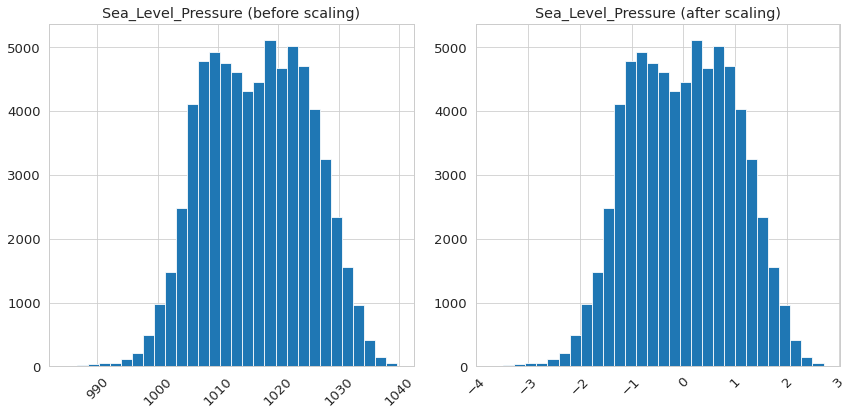

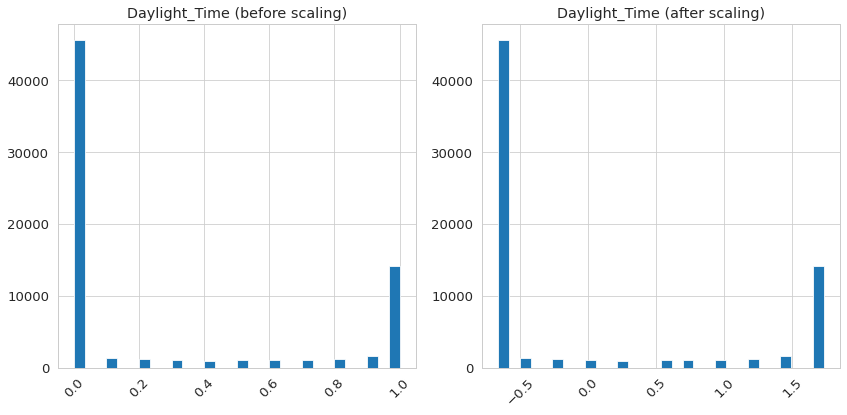

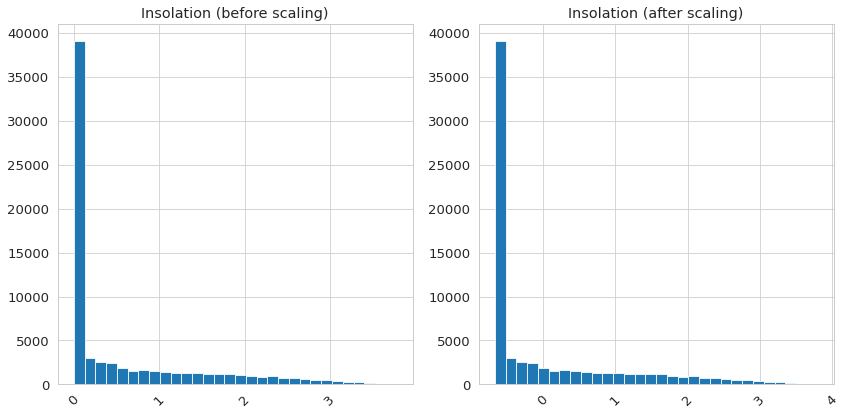

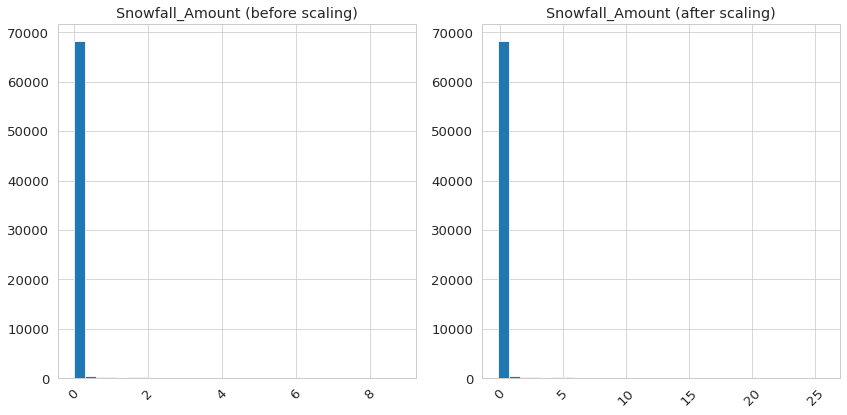

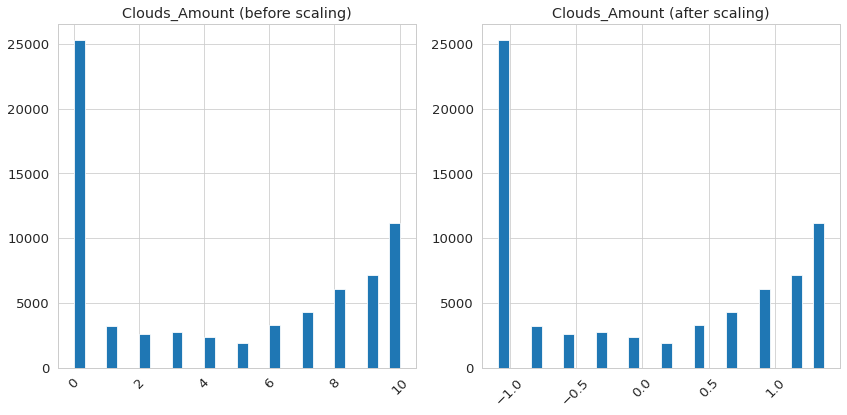

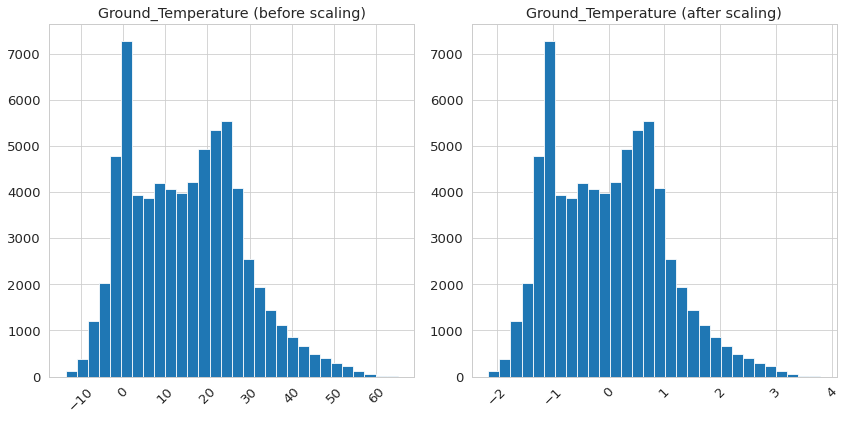

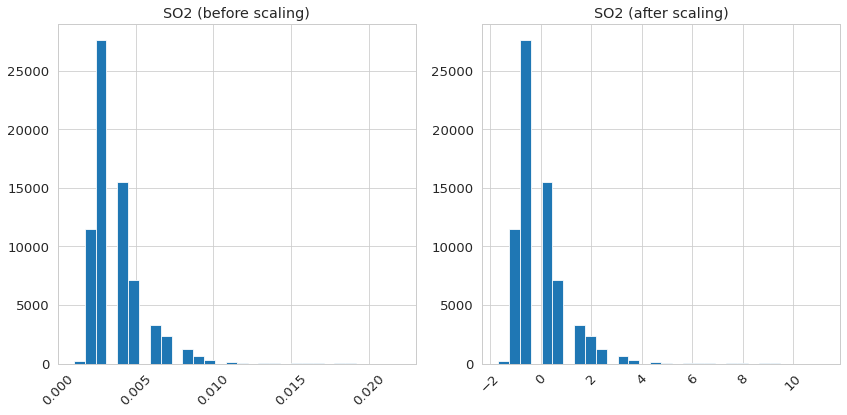

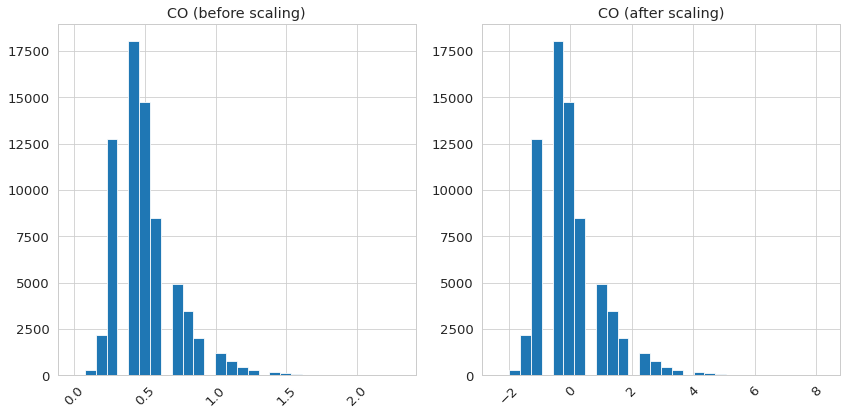

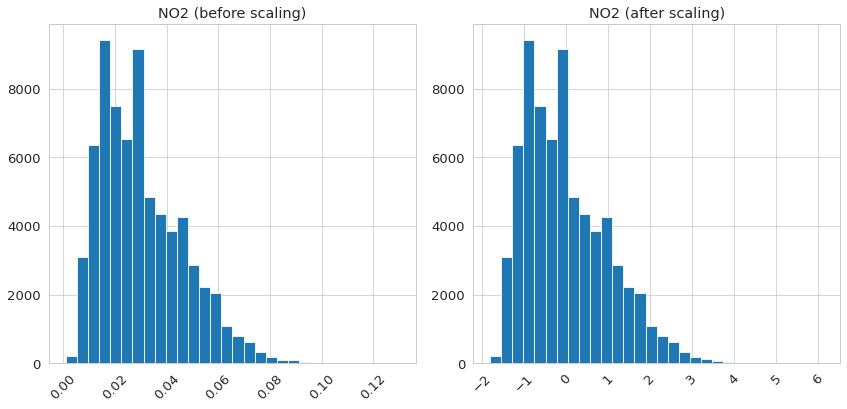

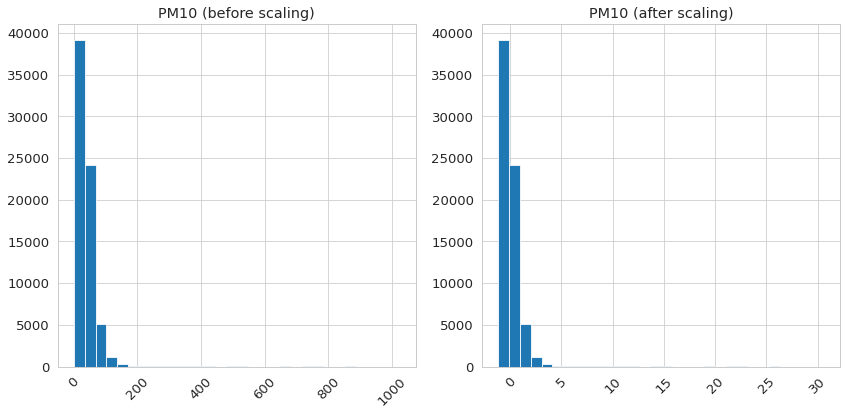

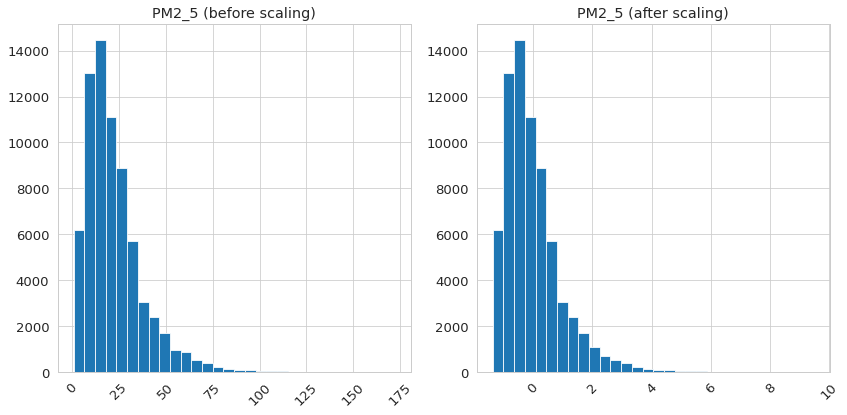

In [114]:
# Plot histograms of each feature before and after scaling
for feature in features:
    plt.figure(figsize=(12, 6))

    # Before scaling
    plt.subplot(1, 2, 1)
    plt.hist(X_origin[feature], bins=30)
    plt.title(f'{feature} (before scaling)')
    plt.xticks(rotation=45)

    # After scaling
    plt.subplot(1, 2, 2)
    plt.hist(X[feature], bins=30)
    plt.title(f'{feature} (after scaling)')
    plt.xticks(rotation=45)

    plt.tight_layout()
    plt.show()

In [139]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [140]:
# Initialize CatBoostRegressor
model = CatBoostRegressor()

In [141]:
# Fit the model
model.fit(X_train, y_train)

Learning rate set to 0.07736
0:	learn: 0.0183834	total: 15.4ms	remaining: 15.4s
1:	learn: 0.0176732	total: 26.6ms	remaining: 13.3s
2:	learn: 0.0170386	total: 36.9ms	remaining: 12.3s
3:	learn: 0.0165003	total: 46.8ms	remaining: 11.7s
4:	learn: 0.0159866	total: 55.4ms	remaining: 11s
5:	learn: 0.0155276	total: 65.5ms	remaining: 10.8s
6:	learn: 0.0150866	total: 74.4ms	remaining: 10.6s
7:	learn: 0.0146944	total: 83.5ms	remaining: 10.3s
8:	learn: 0.0143735	total: 92.8ms	remaining: 10.2s
9:	learn: 0.0140653	total: 102ms	remaining: 10.1s
10:	learn: 0.0137678	total: 112ms	remaining: 10s
11:	learn: 0.0135207	total: 123ms	remaining: 10.1s
12:	learn: 0.0132748	total: 133ms	remaining: 10.1s
13:	learn: 0.0130679	total: 142ms	remaining: 9.98s
14:	learn: 0.0128467	total: 152ms	remaining: 9.97s
15:	learn: 0.0126694	total: 161ms	remaining: 9.92s
16:	learn: 0.0124799	total: 171ms	remaining: 9.89s
17:	learn: 0.0123081	total: 181ms	remaining: 9.87s
18:	learn: 0.0121499	total: 191ms	remaining: 9.88s
19:	lea

In [142]:
# Make predictions
predictions = model.predict(X_test)

In [143]:
# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test, predictions))
print("RMSE: %f" % (rmse))

RMSE: 0.008116


In [144]:
# Calculate MAE
mae = mean_absolute_error(y_test, predictions)
print("MAE: %f" % (mae))

MAE: 0.005840


In [145]:
# Calculate R2 Score
r2 = r2_score(y_test, predictions)
print("R2 Score: %f" % (r2))

R2 Score: 0.821197


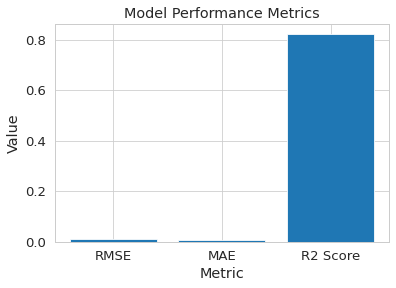

In [147]:
# Your metrics
metrics = {
    'RMSE': rmse,
    'MAE': mae,
    'R2 Score': r2,
}

# Create a bar plot
plt.bar(metrics.keys(), metrics.values())
plt.title('Model Performance Metrics')
plt.xlabel('Metric')
plt.ylabel('Value')
plt.show()

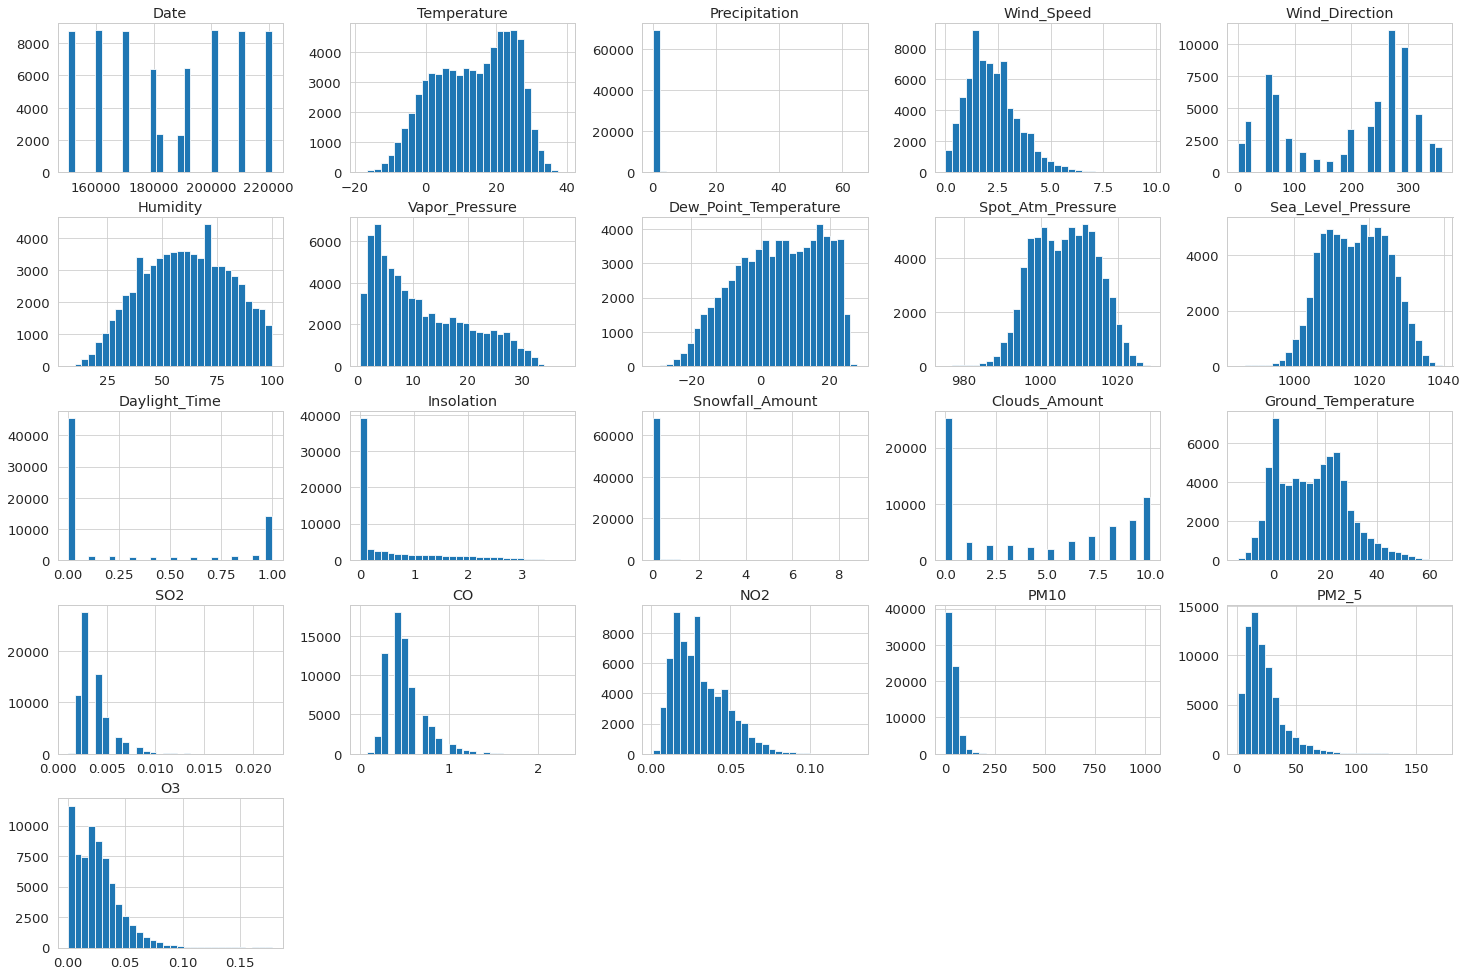

In [146]:
# Histograms for each variable in your dataset
df.hist(bins=30, figsize=(25,17))
plt.show()

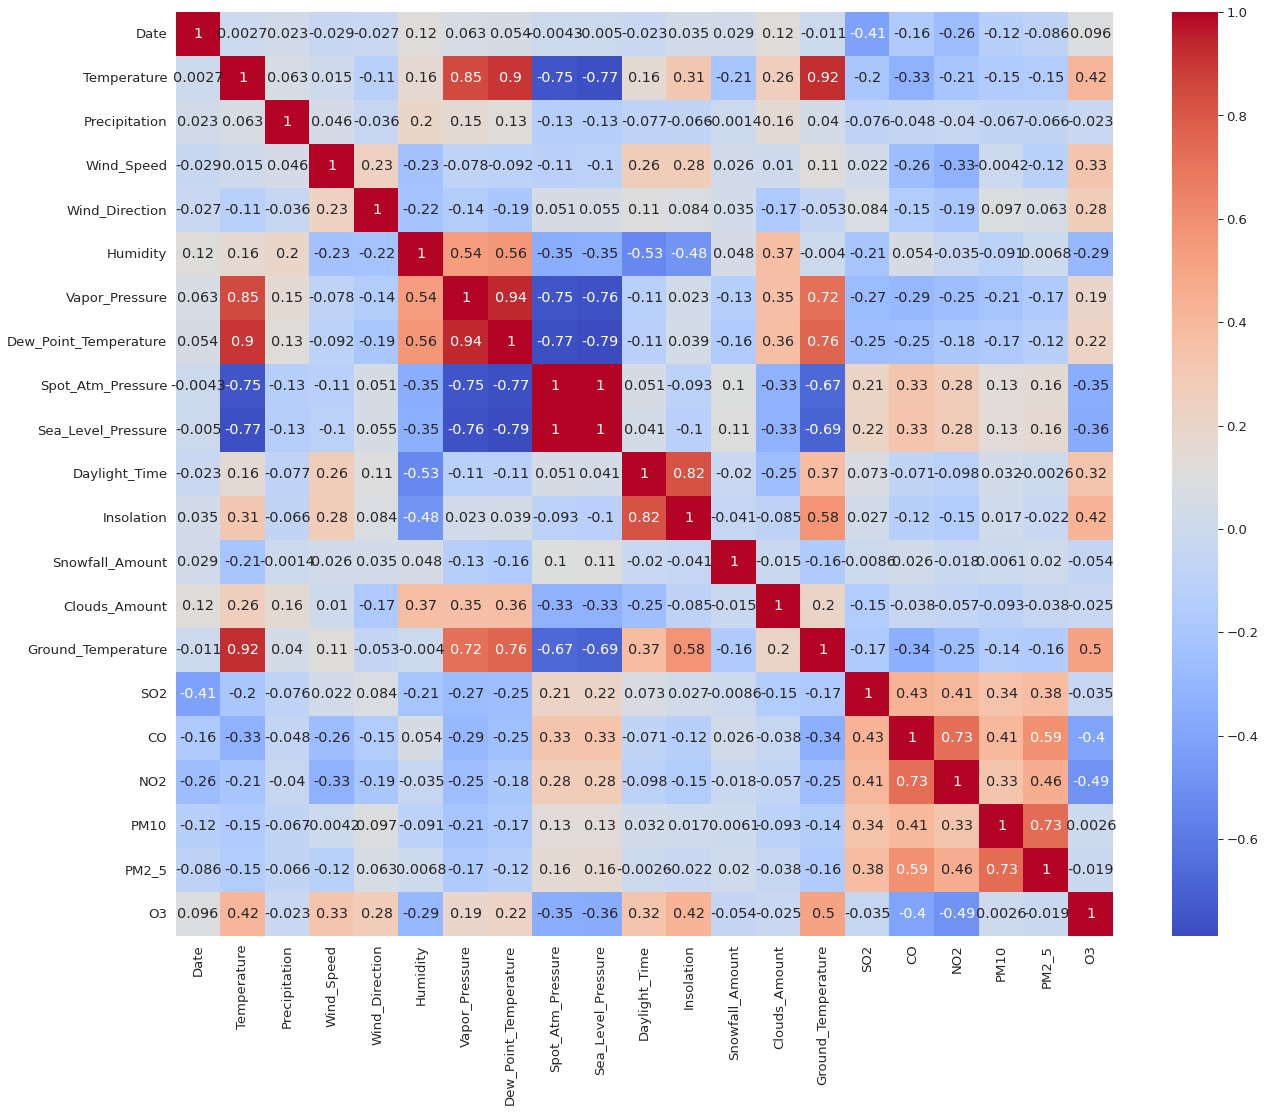

In [57]:
# Heatmap of Correlations
plt.figure(figsize=(21,17))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
plt.show()

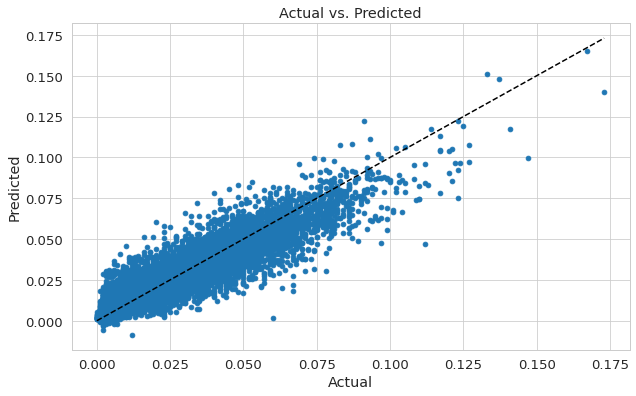

In [61]:
# Plot Actual vs. Predicted
plt.figure(figsize=(10,6))
plt.scatter(y_test, predictions)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=1.5)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs. Predicted')
plt.show()

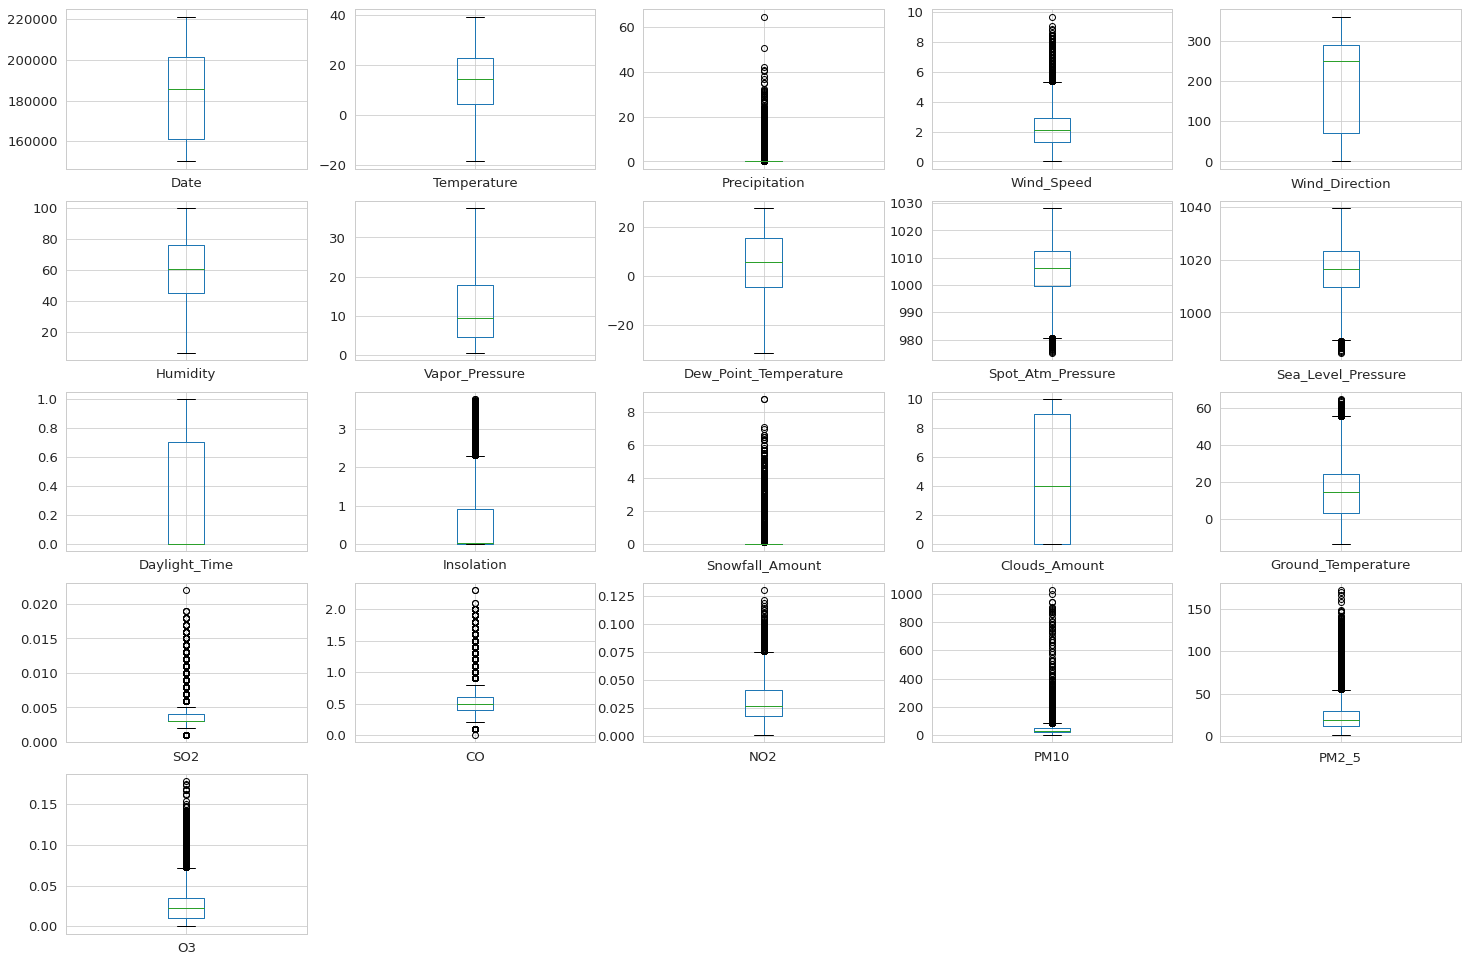

In [68]:
# Box plots for each variable
plt.figure(figsize=(25, 17))
for i, column in enumerate(df.columns, 1):
    plt.subplot(5, 5, i)
    df.boxplot(column)
plt.show()

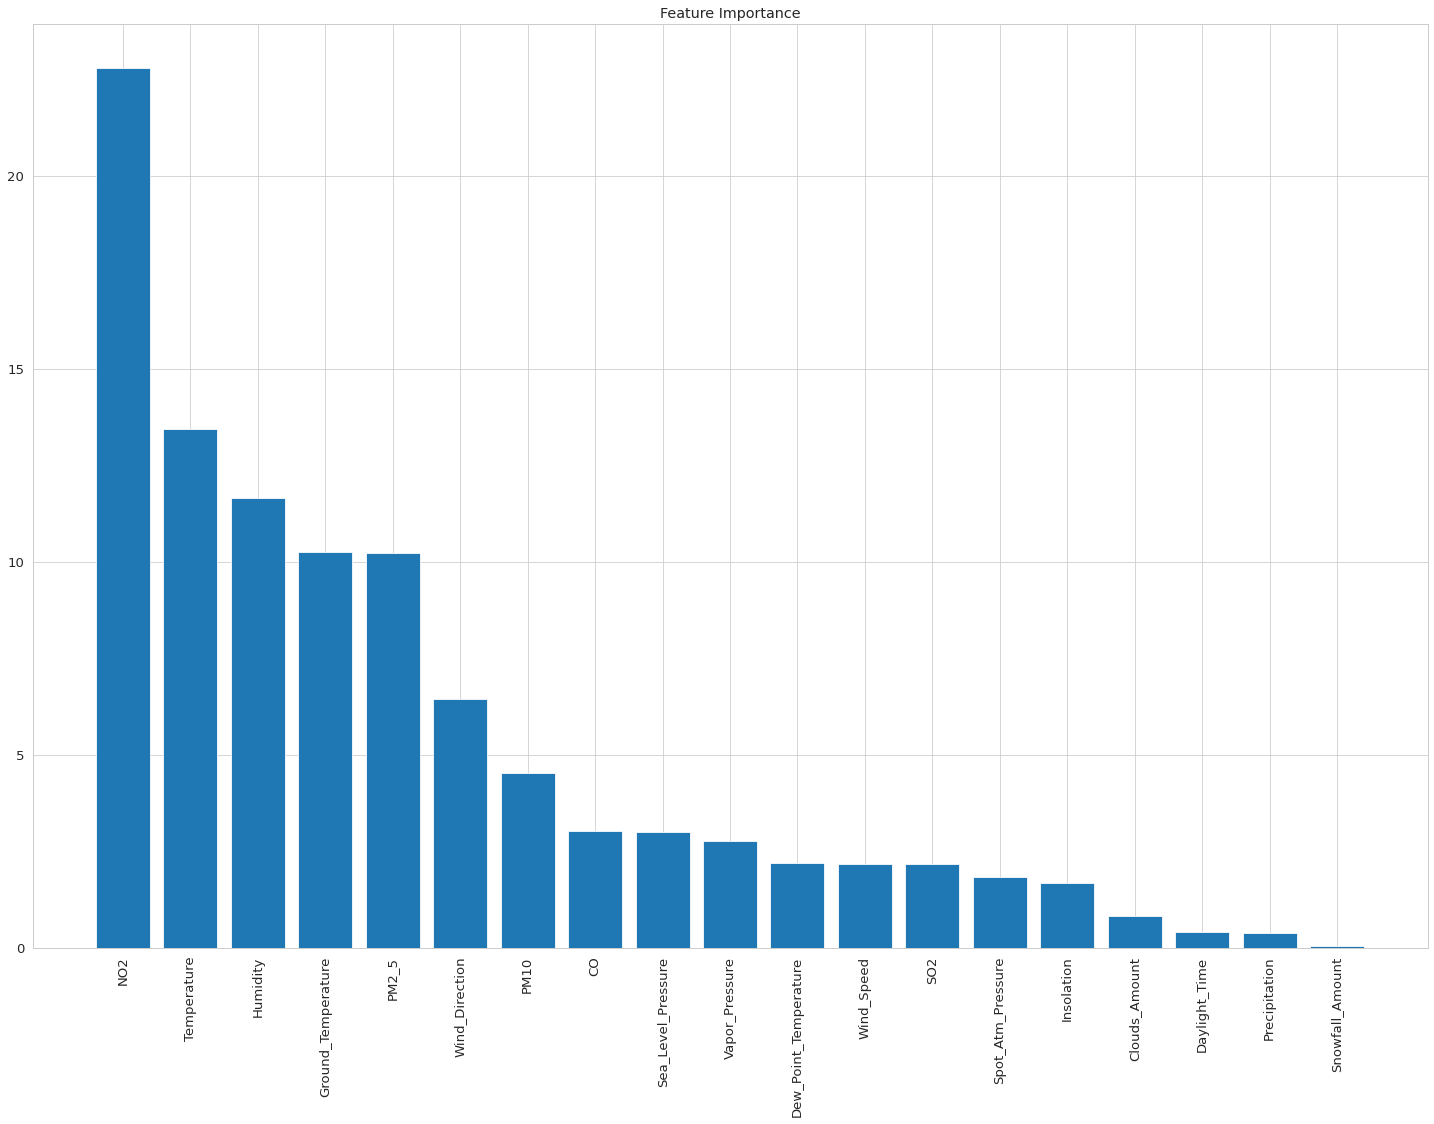

In [70]:
importances = model.feature_importances_
features = X.columns

# Sort feature importances in descending order
indices = np.argsort(importances)[::-1]

# Rearrange feature names so they match the sorted feature importances
names = [features[i] for i in indices]

# Create a plot
plt.figure(figsize=(25,17))

# Create plot title
plt.title("Feature Importance")

# Add bars
plt.bar(range(X.shape[1]), importances[indices])

# Add feature names as x-axis labels
plt.xticks(range(X.shape[1]), names, rotation=90)

# Show plot
plt.show()

### 2. Create New Columns

## Heatmap

<AxesSubplot:>

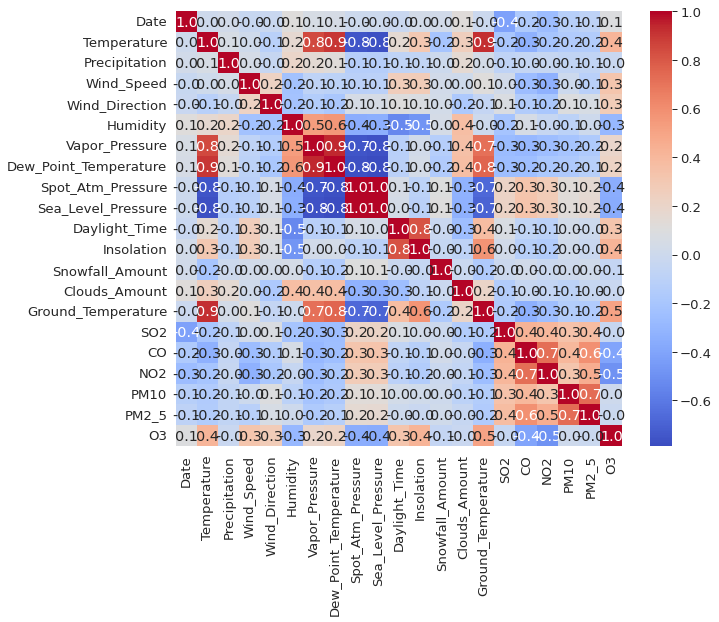

In [40]:
corr = df.corr()

sns.set_style('whitegrid')

sns.set_context('paper', font_scale=1.5)
plt.figure(figsize=(10, 8)) 
sns.heatmap(corr, cmap='coolwarm', annot=True, fmt='.1f')


# Predict

# Model Evaluation Metrics

### MSE

#### 1. Catboost importance

In [45]:
X

,Temperature,Precipitation,Wind_Speed,Wind_Direction,Humidity,Vapor_Pressure,Dew_Point_Temperature,Spot_Atm_Pressure,Sea_Level_Pressure,Daylight_Time,Insolation,Snowfall_Amount,Clouds_Amount,Ground_Temperature,SO2,CO,NO2,PM10,PM2_5
0,0.091090,-0.117299,3.173699,0.872546,0.023922,-0.277440,0.062316,0.016640,0.020957,-0.664091,-0.663714,-0.128939,-1.086208,-0.011793,1.380909,0.418187,-1.190482,0.217916,-0.217863
1,-1.882890,-0.117299,2.023038,0.872546,-1.383442,-1.240545,-2.125726,0.691420,0.767506,-0.664091,-0.663714,-0.128939,-1.086208,-1.472431,1.380909,0.418187,-1.190482,0.155758,-0.977614
2,-1.937220,-0.117299,1.858657,0.872546,-1.282916,-1.240545,-2.117562,0.679151,0.755841,-0.664091,-0.663714,-0.128939,-1.086208,-1.517840,1.380909,0.418187,-1.251986,0.559788,-0.787676
3,-1.973440,-0.117299,1.283326,0.872546,-1.182390,-1.240545,-2.093069,0.728226,0.802500,-0.664091,-0.663714,-0.128939,-1.086208,-1.548112,1.380909,0.418187,-1.251986,1.150292,-0.787676
4,-2.009659,-0.117299,2.187418,0.872546,-1.282916,-1.252435,-2.174712,0.752764,0.837495,-0.664091,-0.663714,-0.128939,-1.086208,-1.578384,1.380909,0.418187,-1.313489,1.461084,-0.724364
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70123,-1.230934,-0.117299,-0.360476,-1.567296,0.627078,-0.860059,-0.778610,1.513424,1.514055,-0.664091,-0.663714,-0.128939,-1.086208,-1.199980,0.153217,2.718350,2.069196,0.808421,2.314638
70124,-1.285263,-0.117299,-0.689237,-1.567296,0.727604,-0.871949,-0.794939,1.464350,1.467395,-0.664091,-0.663714,-0.128939,-0.105301,-1.268093,0.767063,3.178383,2.130700,0.932738,2.314638
70125,-1.303373,-0.117299,-1.100187,1.324368,0.828130,-0.860059,-0.786775,1.476618,1.490725,-0.664091,-0.663714,-0.128939,0.630380,-1.343774,0.153217,3.638415,2.192203,0.870580,2.504576
70126,-1.285263,-0.117299,-1.428948,0.872546,0.878393,-0.848169,-0.754117,1.488887,1.502390,-0.664091,-0.663714,-0.128939,0.875607,-1.298365,0.153217,3.638415,2.192203,0.746263,2.504576


In [46]:
features = [
            'Temperature', 
            'Precipitation', 
            'Wind_Speed', 
            'Wind_Direction', 
            'Humidity', 
            'Vapor_Pressure', 
            'Dew_Point_Temperature', 
            'Spot_Atm_Pressure', 
            'Sea_Level_Pressure',
            'Daylight_Time', 
            'Insolation', 
            'Snowfall_Amount', 
            'Clouds_Amount',
            'Ground_Temperature',
            'SO2',
            'CO',
            'NO2',
            'PM10',
            'PM2_5',
           ]

In [47]:
importances = model.get_feature_importance()
for feature, importance in zip(features, importances):
    print(f"{feature}: {importance}")

Temperature: 13.448198559470448
Precipitation: 0.38405653592017314
Wind_Speed: 2.194446749912004
Wind_Direction: 6.464066202741653
Humidity: 11.6637832060965
Vapor_Pressure: 2.781102964363302
Dew_Point_Temperature: 2.196087879931162
Spot_Atm_Pressure: 1.853299114568236
Sea_Level_Pressure: 2.998329428040501
Daylight_Time: 0.4227282497834453
Insolation: 1.679276131651225
Snowfall_Amount: 0.04818544107480991
Clouds_Amount: 0.8239245732620519
Ground_Temperature: 10.27489506715419
SO2: 2.1826562220565933
CO: 3.0313742417976988
NO2: 22.79780079877278
PM10: 4.529392064886862
PM2_5: 10.226396568516373
